# 🧠 Zense BCI - Recording Analysis Notebook

Interactive analysis of EEG recordings from Zense v0.1.

**Features:**
- Load and visualize recordings
- Extract time/frequency/wavelet features
- Detect artifacts
- SSVEP analysis
- Mental state classification

In [1]:
# Setup - Run this first
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Zense Analysis modules
from Analysis.data_loader import ZenseDataLoader, load_recording
from Analysis.preprocessing import Preprocessor, epoch_data
from Analysis.features import FeatureExtractor, extract_all_features
from Analysis.visualization import plot_recording, plot_bands, plot_spectrogram, plot_mental_state
from Analysis.models.artifact_detector import ArtifactDetector
from Analysis.models.ssvep_detector import SSVEPDetector
from Analysis.models.attention_classifier import AttentionClassifier

print("✅ Zense Analysis modules loaded!")

✅ Zense Analysis modules loaded!


## 1. Load Recording

In [6]:
# List available recordings
loader = ZenseDataLoader('../Recordings/Baseline')
files = loader.list_recordings()

print("Available recordings:")
for i, f in enumerate(files):
    print(f"  {i}: {f.name}")

Available recordings:
  0: SSVEP_test_1_Abhijit_20260205_121913.csv
  1: SSVEP_test_2__swap__Abhijit_20260205_122822.csv


In [ ]:
# Load a specific recording (change index as needed)
recording = loader.load(files[0])

print(f"Loaded: {recording}")
print(f"Duration: {recording.duration_seconds:.1f}s")
print(f"Sample Rate: {recording.sample_rate} Hz")
print(f"Board: {recording.board}")

Loaded: Recording(experiment='SSVEP test 2 (swap)', subject='Abhijit', duration=500.7s, samples=128,188, sample_rate=256Hz)
Duration: 500.7s
Sample Rate: 256 Hz
Board: Arduino UNO Classic


## 2. Visualize Recording

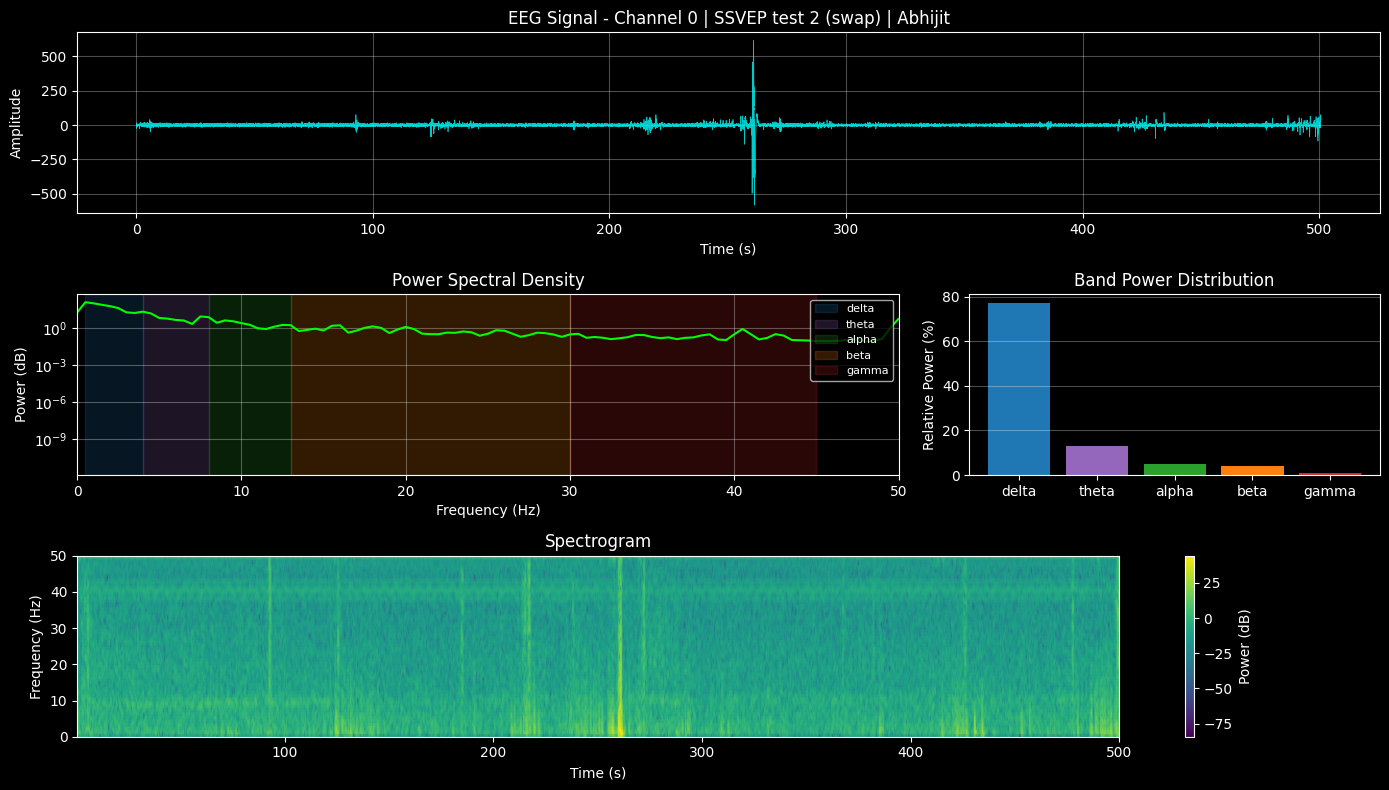

In [8]:
# Full recording overview
fig = plot_recording(recording, channel=0)
plt.show()

In [ ]:
# Band powers over time
fig = plot_bands(recording.filtered_ch0, recording.sample_rate, 
                 title=f"Brain Rhythms - {recording.experiment}")
plt.show()

In [ ]:
# Detailed spectrogram
fig = plot_spectrogram(recording.filtered_ch0, recording.sample_rate,
                       title=f"Time-Frequency - {recording.experiment}")
plt.show()

## 3. Feature Extraction

In [ ]:
# Stack both channels
data = np.vstack([recording.filtered_ch0, recording.filtered_ch1])

# Extract features
feature_extractor = FeatureExtractor(recording.sample_rate)
features = feature_extractor.extract_all(data)

# Display band powers
print("\n📊 Band Power Distribution (Relative %)")
print("-" * 40)
relative = features.band_powers.get('relative', {})
for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
    if band in relative:
        power = np.mean(relative[band])
        bar = '█' * int(power)
        print(f"{band.capitalize():8}: {power:5.1f}% |{bar}")

In [ ]:
# Band ratios (key indicators)
print("\n📈 Key Band Ratios")
print("-" * 40)
for ratio, value in features.band_ratios.items():
    print(f"{ratio:15}: {value:.3f}")

In [ ]:
# Mental state radar chart
band_powers = {band: np.mean(relative[band]) for band in relative if band != 'relative'}
fig = plot_mental_state(band_powers)
plt.show()

## 4. Artifact Detection

In [ ]:
# Detect artifacts
detector = ArtifactDetector(recording.sample_rate)
artifacts = detector.detect_all(data)

print(f"\n🔍 Artifact Detection Results")
print("-" * 40)
print(f"Total artifacts detected: {len(artifacts)}")
print(f"Artifact ratio: {detector.compute_artifact_ratio(data)*100:.1f}%")

# Breakdown by type
report = detector.generate_report(artifacts)
if report['by_type']:
    print("\nBy type:")
    for atype, count in report['by_type'].items():
        print(f"  {atype}: {count}")

## 5. SSVEP Analysis

For recordings with visual stimuli at specific frequencies.

In [ ]:
# SSVEP Detection (modify frequencies for your experiment)
target_frequencies = [10, 12, 15]  # Hz

ssvep = SSVEPDetector(recording.sample_rate, target_frequencies)
results = ssvep.analyze_recording(data, epoch_length=4.0)
summary = ssvep.get_detection_summary(results)

print(f"\n🎯 SSVEP Analysis")
print("-" * 40)
print(f"Detection rate: {summary['detection_rate']*100:.1f}%")
print(f"Dominant frequency: {summary['dominant_frequency']} Hz")
print(f"Mean SNR: {summary['mean_snr']:.1f} dB")
print(f"Mean confidence: {summary['mean_confidence']:.3f}")

## 6. Epoch Analysis

Analyze recording in windows for temporal patterns.

In [ ]:
# Create epochs
preprocessor = Preprocessor(recording.sample_rate)
epochs = preprocessor.create_epochs(data, epoch_length=2.0, overlap=0.5)

print(f"Created {len(epochs)} epochs of 2 seconds each")

# Artifact rejection
epochs = preprocessor.detect_artifacts(epochs)
clean_epochs = preprocessor.reject_artifacts(epochs)
print(f"After artifact rejection: {len(clean_epochs)} clean epochs")

In [ ]:
# Extract features for each epoch
epoch_features = []
for epoch in clean_epochs:
    feat = feature_extractor.extract_all(epoch.data)
    epoch_features.append(feat.to_dict())

# Plot feature over time (e.g., alpha power)
alpha_over_time = [f.get('band_alpha_ch0', 0) for f in epoch_features]
times = [e.start_time for e in clean_epochs]

plt.figure(figsize=(12, 4))
plt.plot(times, alpha_over_time, 'g-', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Alpha Power')
plt.title('Alpha Power Over Session')
plt.grid(True, alpha=0.3)
plt.show()

## 7. Compare Multiple Recordings

In [ ]:
# Load multiple recordings for comparison
from Analysis.visualization import plot_comparison

# Load first 3 recordings (adjust as needed)
recordings = [loader.load(f) for f in files[:3]]

print(f"Comparing {len(recordings)} recordings:")
for r in recordings:
    print(f"  - {r.experiment} ({r.duration_seconds:.0f}s)")

In [ ]:
# Comparison plot
fig = plot_comparison(recordings)
plt.show()

## 8. Save Report

In [ ]:
from Analysis.utils import generate_report

# Generate and display report
report = generate_report(recording, features)
print(report)

In [ ]:
# Save report to file
report = generate_report(recording, features, '../reports/analysis_report.txt')